## Required Imports and Helper functions taken from the coursera project

In [1]:
import matplotlib.pyplot as plt
from scipy.io import wavfile
import os
from pydub import AudioSegment
import numpy as np
import matplotlib.pyplot as plt
from pydub.playback import play
import librosa as lr

# Calculate and plot spectrogram for a wav audio file
def graph_spectrogram(wav_file):
    rate, data = get_wav_info(wav_file)
    nfft = 200 # Length of each window segment
    fs = 8000 # Sampling frequencies
    noverlap = 120 # Overlap between windows
    nchannels = data.ndim
    if nchannels == 1:
        pxx, freqs, bins, im = plt.specgram(data, nfft, fs, noverlap = noverlap)
    elif nchannels == 2:
        pxx, freqs, bins, im = plt.specgram(data[:,0], nfft, fs, noverlap = noverlap)
    return pxx

# Load a wav file
def get_wav_info(wav_file):
    data, rate = lr.load(path=wav_file,sr=16000)
    return rate, data

# Used to standardize volume of audio clip
def match_target_amplitude(sound, target_dBFS):
    change_in_dBFS = target_dBFS - sound.dBFS
    return sound.apply_gain(change_in_dBFS)

# Load raw audio files for speech synthesis
def load_raw_audio():
    positives = []
    backgrounds = []
    negatives = []
    for filename in os.listdir("positives"):
        if filename.endswith("wav"):
            positive = AudioSegment.from_wav("positives/"+filename)
            positives.append(positive)
    for filename in os.listdir("backgrounds"):
        if filename.endswith("wav"):
            background = AudioSegment.from_wav("backgrounds/"+filename)
            backgrounds.append(background)
    for filename in os.listdir("negatives"):
        if filename.endswith("wav"):
            negative = AudioSegment.from_wav("negatives/"+filename)
            negatives.append(negative)
    return positives,negatives, backgrounds

c:\users\buddhima\appdata\local\programs\python\python37\lib\site-packages\pydub\utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
c:\users\buddhima\appdata\local\programs\python\python37\lib\site-packages\pydub\utils.py:179: RuntimeWarning: Couldn't find ffplay or avplay - defaulting to ffplay, but may not work
  warn("Couldn't find ffplay or avplay - defaulting to ffplay, but may not work", RuntimeWarning)


In [6]:
import IPython.display as ipd
#ipd.Audio("positives/1.wav")
#ipd.Audio("negatives/1.wav")
#ipd.Audio("backgrounds_before_processing/white_noise.wav")

### Converting the background noises to 10s clips

In [7]:
ac_noise=AudioSegment.from_wav("backgrounds_before_processing/ac_noise.wav")

In [8]:
time=10*1000
ac_noise_clipped=ac_noise[:time]

In [9]:
ac_noise_clipped.export("backgrounds/ac_noise_clipped.wav",format="wav")

<_io.BufferedRandom name='backgrounds/ac_noise_clipped.wav'>

In [11]:
pink_noise=AudioSegment.from_wav("backgrounds_before_processing/pink_noise.wav")

In [12]:
pink_noise_clipped=pink_noise[:time]

In [13]:
pink_noise_clipped.export("backgrounds/pink_noise_clipped.wav",format="wav")

<_io.BufferedRandom name='backgrounds/pink_noise_clipped.wav'>

In [15]:
white_noise=AudioSegment.from_wav("backgrounds_before_processing/white_noise.wav")

In [16]:
white_noise_clipped=white_noise[:time]

In [18]:
white_noise_clipped.export("backgrounds_before_processing/white_noise_clipped.wav",format="wav")

<_io.BufferedRandom name='backgrounds_before_processing/white_noise_clipped.wav'>

In [20]:
doing_the_dishes_noise=AudioSegment.from_wav("backgrounds_before_processing/doing_the_dishes_noise.wav")

In [21]:
doing_the_dishes_noise_clipped=doing_the_dishes_noise[:time]

In [22]:
doing_the_dishes_noise_clipped.export("backgrounds/doing_the_dishes_noise_clipped.wav",format="wav")

<_io.BufferedRandom name='backgrounds/doing_the_dishes_noise_clipped.wav'>

# The original sampling rates for the noises are:
ac_noise=> 48000
doing_the_dishes_noise=>16000
pink_noise=>16000
white_noise=>16000

In [24]:
rate,audio=get_wav_info("backgrounds_before_processing/white_noise.wav")

In [25]:
rate,audio.shape

(16000, (960000,))

there is a small confusion! the audio part of the ac_noise read using wavfile.read from scipy gives a two dimensional array but if its read using librosa that problem is done, still the no of samples in the ac_noise and ac_noise_clipped is different

In [27]:
rate,audio=get_wav_info("backgrounds_before_processing/ac_noise.wav")

In [28]:
audio.shape,rate

((207872,), 16000)

###          







### Checking if the clipping is proper and analysing various rates and audio files

In [29]:
rate1,audio1=get_wav_info("negatives/1.wav")

In [30]:
print(rate1,audio1.shape)

16000 (16000,)


In [31]:
ipd.Audio(data=audio1,rate=rate1)

## Now all the audio files are ready to be used, you can get the rate and the audio array by just calling the function get_wav_info

In [32]:
rate3,audio3=get_wav_info("negatives/2.wav")

In [33]:
print(rate3,audio3.shape)

16000 (9264,)


In [34]:
ipd.Audio(data=audio3,rate=rate3)

# Starting to build the training dataset

In [35]:
#activates, negatives, backgrounds 
positives,negatives,backgrounds= load_raw_audio()

In [36]:
for audio in negatives:
   # play(audio)

In [37]:
print("background_len:",len(backgrounds[3]))
print("activates_len:",len(positives[11]))
print("negative_len:",len(negatives[2]))

background_len: 10000
activates_len: 464
negative_len: 811


# Helper functions needed to prepare the dataset
1. get_random_time_segment(segment_ms) gets a random time segment in our background audio
2. is_overlapping(segment_time, existing_segments) checks if a time segment overlaps with existing segments
3. insert_audio_clip(background, audio_clip, existing_times) inserts an audio segment at a random time in our background audio 4. using get_random_time_segment and is_overlapping
5. insert_ones(y, segment_end_ms) inserts 1's into our label vector y after the word "activate"

In [38]:
def get_random_time_segment(segment_ms):
    """
    Gets a random time segment of duration segment_ms in a 10,000 ms audio clip.
    
    Arguments:
    segment_ms -- the duration of the audio clip in ms ("ms" stands for "milliseconds")
    
    Returns:
    segment_time -- a tuple of (segment_start, segment_end) in ms
    """
    
    segment_start = np.random.randint(low=0, high=10000-segment_ms)   # Make sure segment doesn't run past the 10sec background 
    segment_end = segment_start + segment_ms - 1
    
    return (segment_start, segment_end)

In [39]:
def is_overlapping(segment_time, previous_segments):
    """
    Checks if the time of a segment overlaps with the times of existing segments.
    
    Arguments:
    segment_time -- a tuple of (segment_start, segment_end) for the new segment
    previous_segments -- a list of tuples of (segment_start, segment_end) for the existing segments
    
    Returns:
    True if the time segment overlaps with any of the existing segments, False otherwise
    """
    
    segment_start, segment_end = segment_time
    
    ### START CODE HERE ### (≈ 4 line)
    # Step 1: Initialize overlap as a "False" flag. (≈ 1 line)
    overlap = False
    
    # Step 2: loop over the previous_segments start and end times.
    # Compare start/end times and set the flag to True if there is an overlap (≈ 3 lines)
    for previous_start, previous_end in previous_segments:
        if segment_start <= previous_end and segment_end >= previous_start:
            overlap = True
    ### END CODE HERE ###

    return overlap

In [40]:
def insert_audio_clip(background, audio_clip, previous_segments):
    """
    Insert a new audio segment over the background noise at a random time step, ensuring that the 
    audio segment does not overlap with existing segments.
    
    Arguments:
    background -- a 10 second background audio recording.  
    audio_clip -- the audio clip to be inserted/overlaid. 
    previous_segments -- times where audio segments have already been placed
    
    Returns:
    new_background -- the updated background audio
    """
    
    # Get the duration of the audio clip in ms
    segment_ms = len(audio_clip)
    
    ### START CODE HERE ### 
    # Step 1: Use one of the helper functions to pick a random time segment onto which to insert 
    # the new audio clip. (≈ 1 line)
    segment_time = get_random_time_segment(segment_ms)
    
    # Step 2: Check if the new segment_time overlaps with one of the previous_segments. If so, keep 
    # picking new segment_time at random until it doesn't overlap. (≈ 2 lines)
    while is_overlapping(segment_time, previous_segments):
        segment_time = get_random_time_segment(segment_ms)

    # Step 3: Add the new segment_time to the list of previous_segments (≈ 1 line)
    previous_segments.append(segment_time)
    ### END CODE HERE ###
    
    # Step 4: Superpose audio segment and background
    new_background = background.overlay(audio_clip, position = segment_time[0])
    
    return new_background, segment_time

In [41]:

audio_clip, segment_time = insert_audio_clip(backgrounds[0], positives[16], [(3790, 4400)])

print("Segment Time: ", segment_time)
#play(audio_clip)

Segment Time:  (8106, 8436)


In [42]:
def insert_ones(y, segment_end_ms):
    """
    Update the label vector y. The labels of the 50 output steps strictly after the end of the segment 
    should be set to 1. By strictly we mean that the label of segment_end_y should be 0 while, the
    50 followinf labels should be ones.
    
    
    Arguments:
    y -- numpy array of shape (1, Ty), the labels of the training example
    segment_end_ms -- the end time of the segment in ms
    
    Returns:
    y -- updated labels
    """
    
    # duration of the background (in terms of spectrogram time-steps)
    segment_end_y = int(segment_end_ms * Ty / 10000.0)
    
    # Add 1 to the correct index in the background label (y)
    ### START CODE HERE ### (≈ 3 lines)
    for i in range(segment_end_y + 1, segment_end_y + 51):
        if i < Ty:
            y[0, i] = 1
    ### END CODE HERE ###
    
    return y

In [43]:
Ty=1375
def create_training_example(background, positives, negatives):
    """
    Creates a training example with a given background, activates, and negatives.
    
    Arguments:
    background -- a 10 second background audio recording
    activates -- a list of audio segments of the word "activate"
    negatives -- a list of audio segments of random words that are not "activate"
    
    Returns:
    x -- the spectrogram of the training example
    y -- the label at each time step of the spectrogram
    """
    
    # Set the random seed
    np.random.seed(18)
    Ty=1375
    # Make background quieter
    background = background - 20
    ### START CODE HERE ###
    # Step 1: Initialize y (label vector) of zeros (≈ 1 line)
    y = np.zeros((1, 1375))

    # Step 2: Initialize segment times as empty list (≈ 1 line)
    previous_segments = []
    ### END CODE HERE ###
    
    # Select 0-4 random "activate" audio clips from the entire list of "activates" recordings
    number_of_positives = np.random.randint(0, 5)
    random_indices = np.random.randint(len(positives), size=number_of_positives)
    random_positives = [positives[i] for i in random_indices]
    
    ### START CODE HERE ### (≈ 3 lines)
    # Step 3: Loop over randomly selected "activate" clips and insert in background
    for random_positive in random_positives:
        # Insert the audio clip on the background
        background, segment_time = insert_audio_clip(background, random_positive, previous_segments)
        # Retrieve segment_start and segment_end from segment_time
        segment_start, segment_end = segment_time
        # Insert labels in "y"
        y = insert_ones(y, segment_end_ms=segment_end)
    ### END CODE HERE ###

    # Select 0-2 random negatives audio recordings from the entire list of "negatives" recordings
    number_of_negatives = np.random.randint(0, 3)
    random_indices = np.random.randint(len(negatives), size=number_of_negatives)
    random_negatives = [negatives[i] for i in random_indices]

    ### START CODE HERE ### (≈ 2 lines)
    # Step 4: Loop over randomly selected negative clips and insert in background
    for random_negative in random_negatives:
        # Insert the audio clip on the background 
        background, _ = insert_audio_clip(background, random_negative, previous_segments)
        
    ### END CODE HERE ###
    
    # Standardize the volume of the audio clip 
    background = match_target_amplitude(background, -20.0)

    # Export new training example 
    file_handle = background.export("train" + ".wav", format="wav")
    print("File (train.wav) was saved in your directory.")
    
    # Get and plot spectrogram of the new recording (background with superposition of positive and negatives)
    x = graph_spectrogram("train.wav")
    
    return x, y,background

File (train.wav) was saved in your directory.


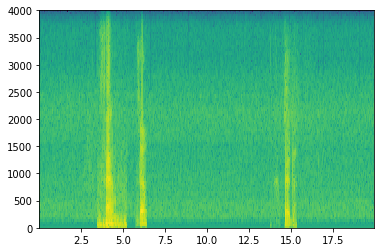

In [48]:
x,y,z=create_training_example(backgrounds[0], positives, negatives)

In [49]:
play(z)